# Necessary Imports and Installs

In [1]:
import sklearn as sk
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


# Playground For Testing

# Tokamak Coils

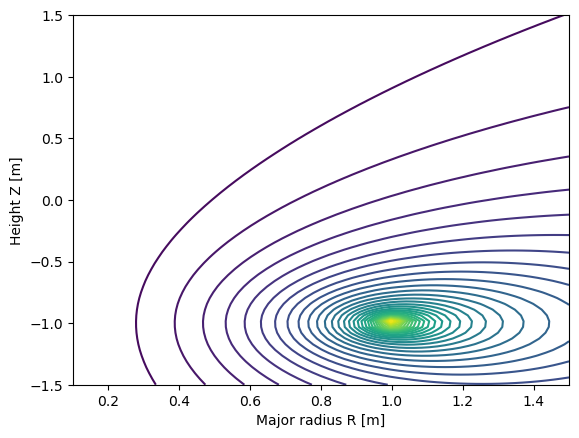

In [4]:
from freegs.coil import Coil

coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA

# Make a 2D grid of R, Z values
# Note: Number of cells 65 = 2^n + 1 is useful later
R, Z = np.meshgrid(np.linspace(0.1, 1.5, 65), np.linspace(-1.5, 1.5, 65), indexing='ij')

# Calculate poloidal flux psi due to coil:
psi = coil_1.psi(R, Z)

plt.contour(R, Z, psi, 40)
plt.xlabel("Major radius R [m]")
plt.ylabel("Height Z [m]")
plt.show()

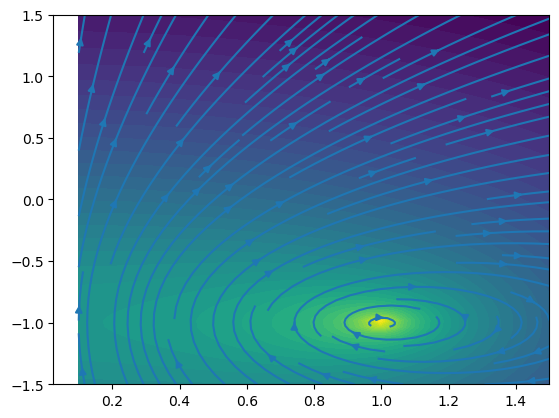

In [5]:
# Radial component of the magnetic field
B_R = coil_1.Br(R, Z)
# Vertical component
B_Z = coil_1.Bz(R, Z)

# Poloidal field magnitude
B_p = np.sqrt(B_R**2 + B_Z**2)

plt.contourf(R, Z, np.log(B_p), 50)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)
plt.show()

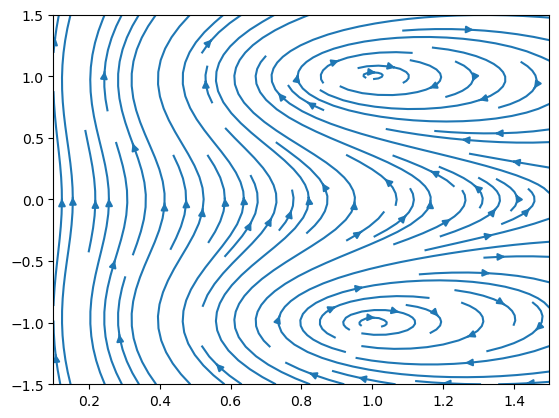

In [6]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = 1e3)  # R = 1m, Z = +1m, current = 1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)
plt.show()


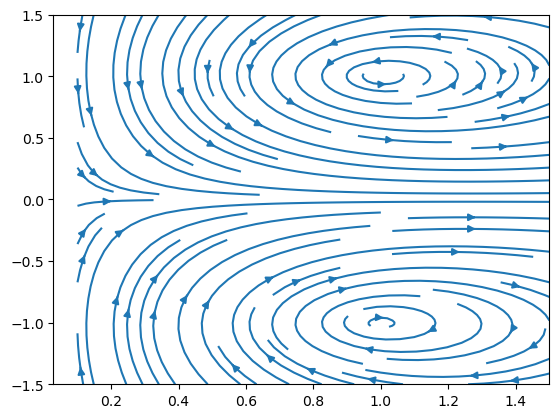

In [8]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = -1e3)  # R = 1m, Z = +1m, current = -1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)
plt.show()

Circuits

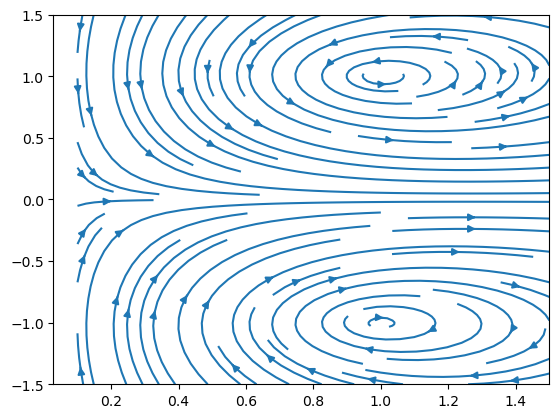

In [10]:
from freegs.machine import Circuit

circuit_1 = Circuit([("P1L", Coil(1.0, -1.0), 1.0),
                    ("P1U", Coil(1.0, 1.0), -1.0)], # Negative so anti-series
                   current = 1e3) # 1kA in this circuit
B_R = circuit_1.Br(R, Z)
B_Z = circuit_1.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)
plt.show()


# Plasma Control

# Setting up an Experiment


In [11]:
# Step 1: Specify the locations of the coils, and the domain you want to solve over

from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.1, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=65, ny=65)        # Number of grid points

In [12]:
# Step 2: Specify the profiles of pressure and f=R*Bt. 
# Currently quite simple functions are supported

from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(eq,  # Equilibrium
                            3e3, # Plasma pressure on axis [Pascals]
                            7e5, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [13]:
# Step 3: Specify the control system and feedback variables.
# The control system adjusts the currents in the poloidal field coils
# to produce X-points in the desired locations, and ensure that the desired
# pairs of locations have the same poloidal flux.

from freegs import control

xpoints = [(0.7, -1.1),   # (R,Z) locations of X-points
           (0.7, 1.1)]

# Contstrain these pairs of (R,Z, R,Z) locations to have the same poloidal flux
# This is needed for radial and vertical position control of the plasma.
isoflux = [(0.7,-1.1, 1.45, 0.0)   # Lower X-point, Outboard midplane
           ,(0.7,1.1, 1.45, 0.0)   # Upper X-point, Outboard midplane
          ]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

In [14]:
# With these three components (coils, profiles and constraints), solve the nonlinear
# system with a Picard iteration. This modifies the "eq" object.

from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

In [15]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 7.000000e+05 Amps


In [16]:
tokamak.printCurrents()

P2U : Coil(R=0.49, Z=1.76, current=15704.8, turns=1, control=True)
P2L : Coil(R=0.49, Z=-1.76, current=15731.9, turns=1, control=True)
P3U : Coil(R=1.1, Z=1.1, current=20660.1, turns=1, control=True)
P3L : Coil(R=1.1, Z=-1.1, current=20697.8, turns=1, control=True)
P4U : Coil(R=1.51, Z=1.095, current=-35416.2, turns=1, control=True)
P4L : Coil(R=1.51, Z=-1.095, current=-35528.5, turns=1, control=True)
P5U : Coil(R=1.66, Z=0.52, current=-147917.3, turns=1, control=True)
P5L : Coil(R=1.66, Z=-0.52, current=-147887.7, turns=1, control=True)
P6U : Coil(R=1.5, Z=0.9, current=-62447.6, turns=1, control=True)
P6L : Coil(R=1.5, Z=-0.9, current=-62420.8, turns=1, control=True)
P1 : Solenoid(Rs=0.15, Zsmin=-1.4, Zsmax=1.4, current=-90189.02268515968, Ns=100, control=True)


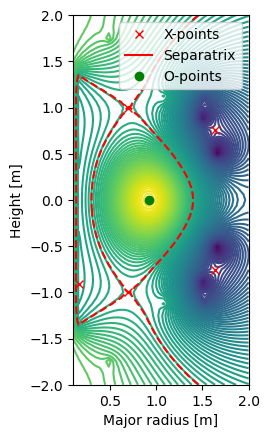

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [25]:
from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)


### Modifying the Equilibrium

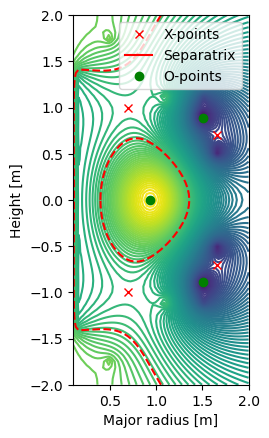

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [22]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)


In [23]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

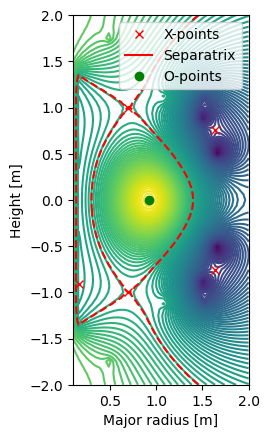

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [24]:
plotEquilibrium(eq)